<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Mini Project 1  - An Exploration of the COVID-19 pandemic in Italy

The early weeks and months of the COVID-19 pandemic were particularly devastating in Italy, as widespread infection had already occured prior to the COVID-19 outbreak being broadcast and designated a pandemic by the World Health Organisation (WHO). In response, the Italian government imposed a lockdown, beginning in the spring of 2020 (Migliaccio et al., 2021). 

I wished to explore data from Google 'BigQuery' on COVID-19 case numbers and mobility measures from Italy Feb-April 2020 to answer the following question:

     1.  Is there evidence that restrictions on individual movement and imposition of residential lockdown reduced          case numbers, deaths and hospitalisations due to COVID-19?
     
In a second exploration, I looked more broadly at COVID-19 case numbers for many countries across the world and combined the data with a number of other metrics obtained from Google BigQuery and the World Bank Databank to answer the following questions:

     2.  Is there a relationship between case numbers (as % of population infected) and number of hospital beds
         per capita?
     
     3.  Is there a relationship between case numbers (as % of population infected) and economic deprivation                (using GDP as a proxy for economic deprivation)?

### 1. Data on COVID-19 case numbers and mobility in Italy after lockdown were obtained from Google BigQuery. 

In [1350]:
from google.cloud import bigquery
from google.cloud.bigquery import Dataset
from google.cloud import storage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [1351]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/gaylecferguson/Data/Labs_3/pristine-valve-352023-4aef7c8e96a6.json"

In [1352]:
project = 'pristine-valve-352023'
client = bigquery.Client.from_service_account_json(key_path, project = project)
print(client.project)  

pristine-valve-352023


  #### 1.1. SQL queries carried out on the google 'bigquery' site
  
  ##### 1.1.1. SQL query to generate table covid_mobility_italy.mobility:
  
    SELECT
      *
    FROM
      `bigquery-public-data.covid19_google_mobility.mobility_report` mobility
    LEFT JOIN
      `bigquery-public-data.covid19_italy.national_trends` italy ON mobility.date = EXTRACT(DATE from italy.date)
    WHERE
       country_region = "Italy"
       AND sub_region_1 IS NULL
       AND sub_region_2 IS NULL
       AND mobility.date BETWEEN "2020-02-01" AND "2020-04-21"
     
  ##### 1.1.2. SQL query to generate table covid_italy.cases:
 
     SELECT * 
     FROM `bigquery-public-data.covid19_italy` 
     LIMIT 1000  
 
  ##### 1.1.3. SQL query to generate table covid_world.covid_world_30April2020
     
     WITH
       country_pop AS (
       SELECT
       country_code AS iso_3166_1_alpha_3,
       year_2018 AS population_2018
       FROM
       `bigquery-public-data.world_bank_global_population.population_by_country`)
     SELECT
       country_code,
       country_name,
       cumulative_confirmed AS april_confirmed_cases,
       population_2018,
       ROUND(cumulative_confirmed/population_2018 * 100,2) AS case_percent
     FROM
       `bigquery-public-data.covid19_open_data.covid19_open_data`
     JOIN
       country_pop
     USING
       (iso_3166_1_alpha_3)
     WHERE
       date = '2020-04-30'
       AND aggregation_level = 0
     ORDER BY
       case_percent DESC

##### 1.1.4. SQL query to generate table covid_world.hospital_beds

    SELECT
      DISTINCT(country_name), AVG(value) AS average_value
    FROM
      `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = "Hospital beds (per 1,000 people)" AND year > 2010
    GROUP BY country_name
    ORDER BY country_name

#### 1.2. List of the datasets in the current project:

In [1353]:
datasets = list(client.list_datasets())
for i in datasets:
    print(i.dataset_id)

covid_italy
covid_mobility_italy
covid_world


#### 1.3. Created a dataset reference object by assigning a project and a dataset name:

In [1354]:
dataset1_id = 'covid_mobility_italy'
dataset1_ref = client.dataset(dataset1_id)
dataset2_id = 'covid_italy'
dataset2_ref = client.dataset(dataset2_id)
dataset3_id = 'covid_world'
dataset3_ref = client.dataset(dataset3_id)

#### 1.4. Printed Table List:

In [1355]:
# function for listing tables in a dataset:
def printTableList(client, dataset_id):
    project = client.project
    dataset_ref = client.dataset(dataset_id, project = project)    
    tables = list(client.list_tables(dataset_ref))
    if tables:
        print('Tables in dataset {}:'.format(dataset_id))
        for table in tables: 
            print('\t{}'.format(table.table_id))
        found = True
    else:
        print('{} dataset does not contain any tables.'.format(dataset_id))
        found = False
    return found

In [740]:
printTableList(client, 'covid_mobility_italy')
printTableList(client, 'covid_italy')
printTableList(client, 'covid_world')

Tables in dataset covid_mobility_italy:
	mobility
Tables in dataset covid_italy:
	cases
Tables in dataset covid_world:
	covid_world_30April2020
	covid_world_30May2022
	hospital_beds


True

#### 1.5. Created a reference to tables within the datasets, using the `table_id` attribute:

In [1356]:
table1_id = 'mobility'
table1_ref = dataset1_ref.table(table1_id)
table2_id = 'cases'
table2_ref = dataset2_ref.table(table2_id)
table3_id = 'covid_world_30April2020'
table3_ref = dataset3_ref.table(table3_id)
table4_id = 'covid_world_30May2022'
table4_ref = dataset3_ref.table(table4_id)
table5_id = 'hospital_beds'
table5_ref = dataset3_ref.table(table5_id)

table1_ref

TableReference(DatasetReference('pristine-valve-352023', 'covid_mobility_italy'), 'mobility')

#### 1.6. Printed Table Schema:

In [1357]:
mobility = client.get_table(table1_ref) # API Request 

In [1358]:
# function to print a table schema:
def printTableSchema(aTable):
    schemas = list(aTable.schema)
    if schemas:
        print('Table schema for {}:'.format(aTable.table_id))
        for aSchema in schemas:
            print('\t{0} {1}'.format(aSchema.name, aSchema.field_type))
        found = True
    else:
        found = False
    return found

In [1359]:
printTableSchema(mobility)

Table schema for mobility:
	country_region_code STRING
	country_region STRING
	sub_region_1 STRING
	sub_region_2 STRING
	metro_area STRING
	iso_3166_2_code STRING
	census_fips_code STRING
	place_id STRING
	date DATE
	retail_and_recreation_percent_change_from_baseline INTEGER
	grocery_and_pharmacy_percent_change_from_baseline INTEGER
	parks_percent_change_from_baseline INTEGER
	transit_stations_percent_change_from_baseline INTEGER
	workplaces_percent_change_from_baseline INTEGER
	residential_percent_change_from_baseline INTEGER
	source_url STRING
	etl_timestamp TIMESTAMP
	date_1 TIMESTAMP
	country STRING
	hospitalized_patients_symptoms INTEGER
	hospitalized_patients_intensive_care INTEGER
	total_hospitalized_patients INTEGER
	home_confinement_cases INTEGER
	total_current_confirmed_cases INTEGER
	new_current_confirmed_cases INTEGER
	new_total_confirmed_cases INTEGER
	recovered INTEGER
	deaths INTEGER
	total_confirmed_cases INTEGER
	tests_performed INTEGER
	note STRING


True

#### 1.7. Converted BigQuery Table to Pandas DataFrame

In [1360]:
sql = """
    SELECT * 
    FROM `pristine-valve-352023.covid_mobility_italy.mobility` 
    """
query_job = client.query(sql)
mobility = client.query(sql).to_dataframe()

### 2. EDA - Italy COVID-19 case numbers and impact of lockdown on 'mobility', Feb-April 2020

In the dataframe below the 'motility' measures are given as 'percent change from baseline'. The baseline data is not within this dataset, but is assumed to be a measure of normal retail, recreation, parks and workplace "traffic" for this time of year, prior to the lockdown order. 

In [1361]:
print("Mobility table rows x columns: ", mobility.shape)
mobility.sample(5)

Mobility table rows x columns:  (67, 31)


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,...,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed,note
14,IT,Italy,None,None,None,None,None,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-04-01,-90,...,32438,48134,80572,2937,4782,16847,13155,110574,541423,None
4,IT,Italy,None,None,None,None,None,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-19,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,None
61,IT,Italy,None,None,None,None,None,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-03-08,-32,...,4207,2180,6387,1326,1492,622,366,7375,49937,None
29,IT,Italy,None,None,None,None,None,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-03-29,-94,...,31292,42588,73880,3815,5217,13030,10779,97689,454030,pd-IT-0009
64,IT,Italy,None,None,None,None,None,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-03-03,-7,...,1263,1000,2263,428,466,160,79,2502,25856,None


#### 2.1. Deleted unneeded columns from the DataFrame

In [1362]:
mobility = mobility.drop(labels=["country_region_code", "country", "date_1", "sub_region_1", "sub_region_2", "metro_area", "iso_3166_2_code", "census_fips_code", "place_id", "note"], axis='columns')
mobility = mobility.drop(labels=["source_url"], axis='columns')
#mobility = mobility.drop(labels=["total_hospitalized_patients", "home_confinement_cases", "total_current_confirmed_cases", "new_current_confirmed_cases", "new_total_confirmed_cases", "recovered", "deaths", "total_confirmed_cases", "tests_performed"], axis='columns')
mobility.sample(5)

,country_region,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,etl_timestamp,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed
13,Italy,2020-04-02,-90,-40,-77,-79,-70,34,2022-06-10 00:04:50.466367+00:00,28540,4053,32593,50456,83049,2477,4668,18278,13915,115242,581232
41,Italy,2020-04-21,-79,-45,-76,-77,-61,29,2022-06-10 00:04:50.466367+00:00,24134,2471,26605,81104,107709,-528,2729,51600,24648,183957,1450150
26,Italy,2020-03-28,-87,-54,-86,-82,-65,27,2022-06-10 00:04:50.466367+00:00,26676,3856,30532,39533,70065,3651,5974,12384,10023,92472,429526
32,Italy,2020-03-21,-86,-51,-85,-80,-63,26,2022-06-10 00:04:50.466367+00:00,17708,2857,20565,22116,42681,4821,6557,6072,4825,53578,233222
50,Italy,2020-03-11,-52,-14,-32,-57,-37,19,2022-06-10 00:04:50.466367+00:00,5838,1028,6866,3724,10590,2076,2313,1045,827,12462,73154


#### 2.2. Checked for 'nulls'

'N/A' values were present in the first 9 rows of each of the columns giving COVID-19 case numbers.  These represent dates early in the month of Feb, where accurate case numbers were probably not collected.  I did not remove these rows from the dataset at this stage.  

In [1363]:
# Checking for nulls
# Nine entries are missing case data
mobility.isnull().sum()

country_region                                        0
date                                                  0
retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    0
transit_stations_percent_change_from_baseline         0
workplaces_percent_change_from_baseline               0
residential_percent_change_from_baseline              0
etl_timestamp                                         0
hospitalized_patients_symptoms                        9
hospitalized_patients_intensive_care                  9
total_hospitalized_patients                           9
home_confinement_cases                                9
total_current_confirmed_cases                         9
new_current_confirmed_cases                           9
new_total_confirmed_cases                             9
recovered                                             9
deaths                                          

In [1364]:
# Examining the nine entries with missing case data:
# These are all from dates in Feb 2020
# I will leave these in as I'm most interested in the 'mobility' data from this table, and these early entries show
# mobility data prior to lock-down
mobility.loc[mobility['hospitalized_patients_symptoms'].isna()]

,country_region,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,etl_timestamp,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed
0,Italy,2020-02-21,1,1,19,5,0,-1,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Italy,2020-02-22,-1,3,30,8,0,-1,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Italy,2020-02-15,3,-1,35,9,0,-1,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Italy,2020-02-17,0,1,7,3,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Italy,2020-02-19,0,-1,11,3,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,Italy,2020-02-18,3,1,16,4,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,Italy,2020-02-20,2,1,18,5,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,Italy,2020-02-23,-5,16,23,6,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,Italy,2020-02-16,3,2,26,11,1,-2,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#### 2.2. Descriptive Statistics for the 'mobility' dataset

Values for COVID-19 case numbers are very high compared to values for mobility changes relative to baseline, which will present some challenges for representing the data graphically. 

In [761]:
# Examining data means and ranges
mobility.describe()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,5.800000e+01
mean,-55.776119,-29.462687,-47.149254,-54.656716,-43.134328,19.820896,16808.068966,2291.344828,19099.431034,32917.051724,52016.465517,1853.241379,3171.534483,14317.206897,8986.500000,75320.172414,4.494637e+05
std,37.061710,28.043974,42.183313,33.480230,28.148898,13.165526,11400.650488,1449.119546,12814.621209,29567.820145,41335.496350,1433.837169,1869.215158,15691.457694,8648.733706,64739.692217,4.442664e+05
min,-96.000000,-94.000000,-91.000000,-91.000000,-90.000000,-2.000000,101.000000,26.000000,127.000000,94.000000,221.000000,-528.000000,78.000000,1.000000,7.000000,229.000000,4.324000e+03
25%,-83.500000,-45.500000,-79.500000,-79.000000,-65.500000,5.500000,4496.500000,769.000000,5265.500000,2683.250000,8117.250000,544.250000,1568.250000,794.000000,505.000000,9416.250000,5.555975e+04
50%,-79.000000,-37.000000,-75.000000,-76.000000,-61.000000,25.000000,21314.500000,2694.000000,24614.500000,27609.500000,52224.000000,1631.500000,3495.000000,7879.000000,6448.500000,66551.500000,2.862160e+05
75%,-12.500000,-1.000000,-3.500000,-23.500000,-12.000000,31.000000,27834.000000,3578.000000,31261.500000,61246.000000,93847.000000,2877.750000,4647.250000,24003.250000,16976.000000,134826.250000,7.470168e+05
max,3.000000,23.000000,35.000000,11.000000,1.000000,40.000000,29010.000000,4068.000000,33004.000000,81104.000000,108257.000000,4821.000000,6557.000000,51600.000000,24648.000000,183957.000000,1.450150e+06


#### 2.3. Looking at Correlations

I looked for significant correlations of interest between variables in the 'mobility' dataset.  While many contrasts were significantly correlated, none were deemed worthy of further exploration.  It is rather trivial, for example, to note a high correlation between high case numbers and reduced 'mobility' as the lockdown order that reduced mobility came as government response to high case numbers - so the correlation between these features cannot be considered causal. 

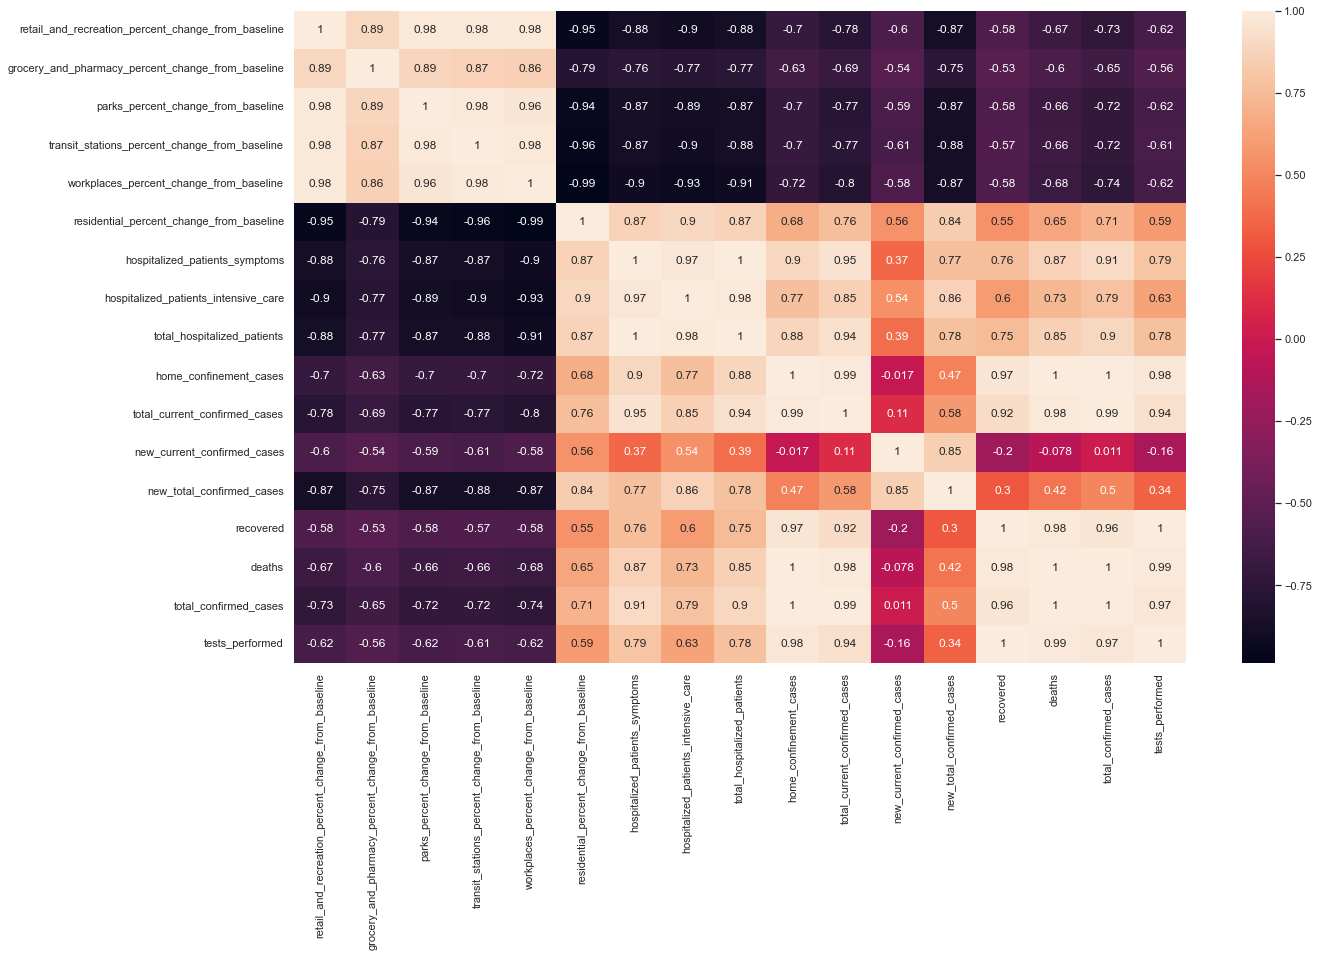

In [604]:
import seaborn as sns

# Correlation matrix for variables
corr = mobility.corr()

# plot as a heatmap

fig, ax = plt.subplots(figsize=(20, 12))
ax = sns.heatmap(corr, annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#### 2.4. Reordering Data

In [1365]:
# On plotting the data it became apparent that the dates are not in order.
# So I went back and sorted the data by date, replaced the df, then reset the index. 
# Set date as index
mobility = mobility.sort_values("date")
mobility = mobility.set_index("date")
mobility.head()

,country_region,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,etl_timestamp,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed
date,,,,,,,,,,,,,,,,,,,
2020-02-15,Italy,3,-1,35,9,0,-1,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-16,Italy,3,2,26,11,1,-2,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-17,Italy,0,1,7,3,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-18,Italy,3,1,16,4,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-19,Italy,0,-1,11,3,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#### 2.5. Computing 7-day Rolling Averages for Curve Smoothing

Initial plots of data (shown several cells below) showed 'jagged' lines, indicitive of high variability between day to day activity and the impact of behaviour changes at weekends.  In order to view overall trends it was necessary to compute 7-day rolling averages to smooth out daily variation. 

In [1366]:
# Need to smooth curves by caluclating rolling averages
# I tried rolling averages of 3 days, 4 days, 5 days and 7 days and plotted these as line plots
# The 7-day rolling average gave the best result...
# ...which is expected as there are usually different patterns of behaviour on weekends vs week days. 

# Program to calculate moving average
# Code from here: https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/#:~:text=Method%201%3A%20Using%20Numpy&text=sum()%20which%20returns%20the,dividing%20it%20with%20window%20size.

retail_rec = np.array(mobility["retail_and_recreation_percent_change_from_baseline"])
window_size = 7
i = 0
# Initialize an empty list to store moving averages
retail_rec_mv_avg_7day = []
  
# Loop through the array to consider every window of size 3
while i < len(retail_rec) - window_size + 1:
    
    #Store elements from i to i+window_size in list to get the current window
    window = retail_rec[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current window in moving average list
    retail_rec_mv_avg_7day.append(window_average)
      
    # Shift window to right by one position
    i += 1

In [1367]:
# I inserted values for day 1-6 at start of each array to account for missing values prior to the first 7-day window. 
# Have inserted '0' for the missing dates, to represent baseline activity. ('0' = baseline behaviour)
retail_rec_mv_avg_7day = np.insert(retail_rec_mv_avg_7day, 0, [0,0,0,0,0,0])

# Insert new column into 'mobility' dataframe
mobility.insert(2, "retail_rec_mv_avg_7day", retail_rec_mv_avg_7day)
mobility.head()

,country_region,retail_and_recreation_percent_change_from_baseline,retail_rec_mv_avg_7day,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,etl_timestamp,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed
date,,,,,,,,,,,,,,,,,,,,
2020-02-15,Italy,3,0.0,-1,35,9,0,-1,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-16,Italy,3,0.0,2,26,11,1,-2,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-17,Italy,0,0.0,1,7,3,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-18,Italy,3,0.0,1,16,4,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-19,Italy,0,0.0,-1,11,3,1,0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#### 2.6. Plotting 7-day Rolling Averages for 'Mobility' Data (Retail & Recreation)

In the plot below, the smoothing impact of taking 7-day rolling averages is evident.   A sharp decline in shopping and recreation activity can be seen following the lockdown order.


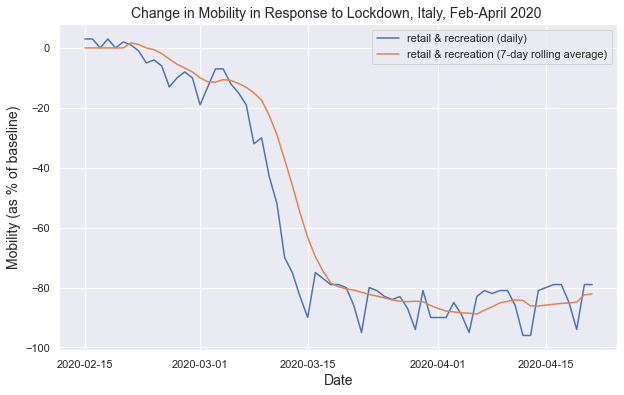

In [1368]:
# Lineplot of 7-day rolling average alongside daily plot

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10, 6)
sns.set(color_codes = True)


# Plot
retailrec = sns.lineplot(data=mobility["retail_and_recreation_percent_change_from_baseline"], palette = 'blue', label = 'retail & recreation (daily)')
retailrec_7dayavg = sns.lineplot(data=mobility["retail_rec_mv_avg_7day"], palette = 'orange', label = 'retail & recreation (7-day rolling average)')

plt.xlabel("Date", fontsize=14)
plt.ylabel("Mobility (as % of baseline)", fontsize=14)
plt.title("Change in Mobility in Response to Lockdown, Italy, Feb-April 2020 ", fontsize=14)
plt.legend()
plt.show()

#### 2.6. Computed and Plotted 7-day Rolling Averages for other 'Mobility' Data (Grocery & Pharmacy, Parks, Transit, Workplace, Residential)

In [1378]:
# Calculated 7-day rolling average for other 'mobility' measures

groc_pharm = np.array(mobility["grocery_and_pharmacy_percent_change_from_baseline"])
parks = np.array(mobility["parks_percent_change_from_baseline"])
transit = np.array(mobility["transit_stations_percent_change_from_baseline"])
workplace = np.array(mobility["workplaces_percent_change_from_baseline"])
residential = np.array(mobility["residential_percent_change_from_baseline"])

window_size = 7
i = 0

# Initialize empty lists to store moving averages

#groc_pharm_mv_avg_7day = []
#parks_mv_avg_7day = []
#transit_mv_avg_7day = []
#workplace_mv_avg_7day = []
#residential_mv_avg_7day = []

# Loop through the array to consider every window of size 7
while i < len(parks) - window_size + 1:
    
    #Store elements from i to i+window_size in list to get the current window
    window = parks[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current window in moving average list
    parks_mv_avg_7day.append(window_average)
      
    # Shift window to right by one position
    i += 1

In [1402]:
# Inserted baseline values for day 1-6 at start of arrays

#groc_pharm_mv_avg_7day = np.insert(groc_pharm_mv_avg_7day, 0, [0,0,0,0,0,0])
#parks_mv_avg_7day = np.insert(parks_mv_avg_7day, 0, [0,0,0,0,0,0])
#transit_mv_avg_7day = np.insert(transit_mv_avg_7day, 0, [0,0,0,0,0,0])
#workplace_mv_avg_7day = np.insert(workplace_mv_avg_7day, 0, [0,0,0,0,0,0])
#residential_mv_avg_7day = np.insert(residential_mv_avg_7day, 0, [0,0,0,0,0,0])

# Insert new columns into 'mobility' dataframe
#mobility.insert(6, "residential_mv_avg_7day", residential_mv_avg_7day)

# Dropped the non-rolling columns:
#mobility = mobility.drop(labels=["residential_percent_change_from_baseline"], axis='columns')
mobility.head()

,country_region,retail_rec_mv_avg_7day,groc_pharm_mv_avg_7day,parks_mv_avg_7day,transit_mv_avg_7day,workplace_mv_avg_7day,residential_mv_avg_7day,etl_timestamp,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed
date,,,,,,,,,,,,,,,,,,,
2020-02-15,Italy,0.0,0.0,0.0,0.0,0.0,0.0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-16,Italy,0.0,0.0,0.0,0.0,0.0,0.0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-17,Italy,0.0,0.0,0.0,0.0,0.0,0.0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-18,Italy,0.0,0.0,0.0,0.0,0.0,0.0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-19,Italy,0.0,0.0,0.0,0.0,0.0,0.0,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


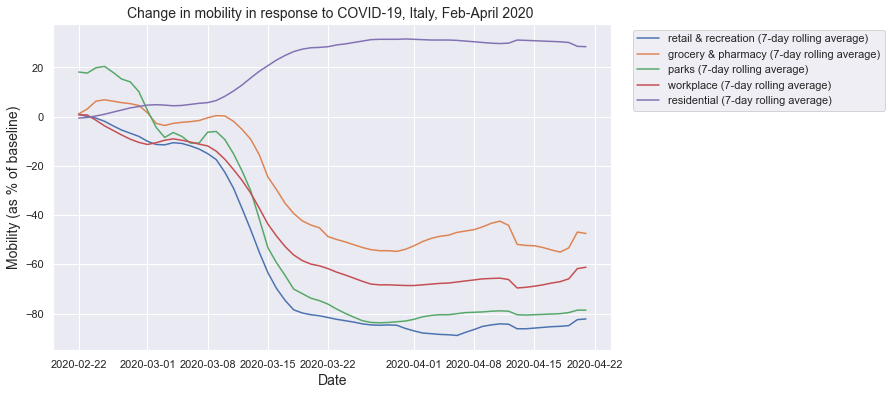

In [790]:
# Lineplots of 7-day rolling averages alongside daily plots

retailrec_7dayavg = sns.lineplot(data=mobility.retail_rec_mv_avg_7day[7:], palette = 'blue', label = 'retail & recreation (7-day rolling average)')
grocpharm_7dayavg = sns.lineplot(data=mobility.groc_pharm_mv_avg_7day[7:], palette = 'orange', label = 'grocery & pharmacy (7-day rolling average)')
parks_7dayavg = sns.lineplot(data=mobility.parks_mv_avg_7day[7:], palette = 'green', label = 'parks (7-day rolling average)')
workplace_7dayavg = sns.lineplot(data=mobility.workplace_mv_avg_7day[7:], palette = 'magenta', label = 'workplace (7-day rolling average)')
residential_7dayavg = sns.lineplot(data=mobility.residential_mv_avg_7day[7:], palette = 'purple', label = 'residential (7-day rolling average)')

plt.xlabel("Date", fontsize=14)
plt.ylabel("Mobility (as % of baseline)", fontsize=14)
plt.title("Change in mobility in response to COVID-19, Italy, Feb-April 2020 ", fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 1, 1))
plt.show()

All curves for the restricted mobility measures follow the same shape, declining sharply after lockdown began.  In contrast, residential occupany increases.  Interestingly, the 'parks' line is markedly above baseline for the last week of Feb, prior to lockdown, indicating higher than usual park use at the time.  The reason for this is unknown; perhaps better than usual weather for late February?

#### 2.7. Conclusion: Lockdown resulted in sharp declines in all activities outside of residences. 

### 3. EDA - Italy COVID-19 case numbers, Feb-April 2020

#### 3.1. Plotted some of the COVID-19 case counts to see the shape of the data

Curves look smooth for cumulative data with high numbers, such as 'deaths' (green line), but daily tallies of new and total case numbers fluctuate due to daily variability.  Once again, the appearance of the line graphs can be improved by computing rolling 7-day averages to smooth out variability and reveal trends. 

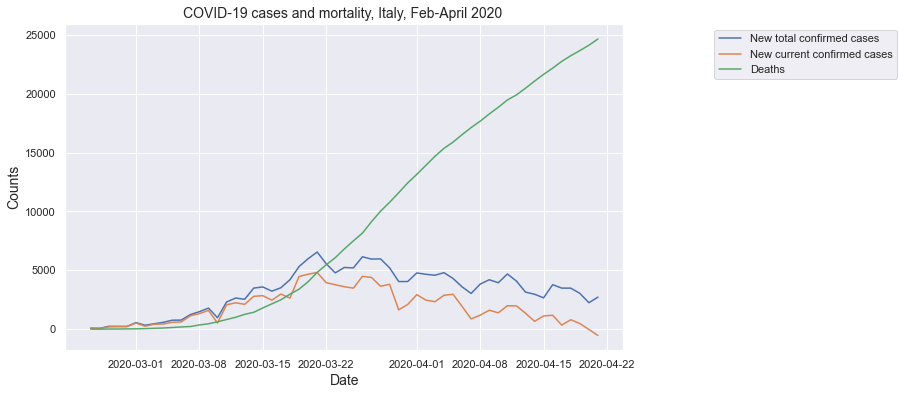

In [791]:
# Lineplots of COVID-19 count data
sns.lineplot(data=mobility.new_total_confirmed_cases[10:], palette = 'blue', label = 'New total confirmed cases')
sns.lineplot(data=mobility.new_current_confirmed_cases[10:], palette = 'orange', label = 'New current confirmed cases')
sns.lineplot(data=mobility.deaths[10:], palette = 'green', label = 'Deaths')

plt.xlabel("Date", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("COVID-19 cases and mortality, Italy, Feb-April 2020 ", fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 1, 1))
plt.show()

#### 3.2. Computing 7-day Rolling Averages of Case Data for Curve Smoothing

In [1406]:
# Calculated 7-day rolling average for some of the covid case data

#new_total_confirmed_cases = np.array(mobility.new_total_confirmed_cases[10:])
#new_current_confirmed_cases = np.array(mobility.new_current_confirmed_cases[10:])

window_size = 7
i = 0

# Initialize an empty list to store moving averages
#new_current_confirmed_cases_7day = []
#new_current_confirmed_cases_7day = []

# Loop through the array to consider every window of size 7
while i < len(new_current_confirmed_cases) - window_size + 1:
    
    #Store elements from i to i+window_size in list to get the current window
    window = new_current_confirmed_cases[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current window in moving average list
    new_current_confirmed_cases_7day.append(window_average)
      
    # Shift window to right by one position
    i += 1

In [1410]:
# Inserted baseline values for day 1-6 at start of arrays

#new_total_confirmed_cases_7day = np.insert(new_total_confirmed_cases_7day, 0, [0,0,0,0,0,0,0,0,0])
#new_current_confirmed_cases_7day = np.insert(new_current_confirmed_cases_7day, 0, [0,0,0,0,0,0,0,0,0])

# Insert new columns into 'mobility' dataframe
#mobility.insert(16, "new_total_confirmed_cases_7day", new_total_confirmed_cases_7day)

In [1414]:
# Converted first nine values for to NaN, consitent with the surrounding columns

#mobility.new_current_confirmed_cases_7day[:9] = mobility.new_current_confirmed_cases_7day[:9].replace(0, np.nan)
#mobility.new_total_confirmed_cases_7day[:9] = mobility.new_total_confirmed_cases_7day[:9].replace(0, np.nan)
mobility.head(18)

,country_region,retail_rec_mv_avg_7day,groc_pharm_mv_avg_7day,parks_mv_avg_7day,transit_mv_avg_7day,workplace_mv_avg_7day,residential_mv_avg_7day,etl_timestamp,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,...,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_current_confirmed_cases_7day,new_total_confirmed_cases,new_total_confirmed_cases_7day,recovered,deaths,total_confirmed_cases,tests_performed
date,,,,,,,,,,,,,,,,,,,,,
2020-02-15,Italy,0.00,0.00,0.00,0.00,0.00,0.00,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-16,Italy,0.00,0.00,0.00,0.00,0.00,0.00,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-17,Italy,0.00,0.00,0.00,0.00,0.00,0.00,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-18,Italy,0.00,0.00,0.00,0.00,0.00,0.00,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-19,Italy,0.00,0.00,0.00,0.00,0.00,0.00,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-20,Italy,0.00,0.00,0.00,0.00,0.00,0.00,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-21,Italy,1.71,0.57,18.86,5.71,0.71,-0.57,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-22,Italy,1.14,1.14,18.14,5.57,0.71,-0.57,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
2020-02-23,Italy,0.00,3.14,17.71,4.86,0.71,-0.29,2022-06-10 00:04:50.466367+00:00,<NA>,<NA>,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>


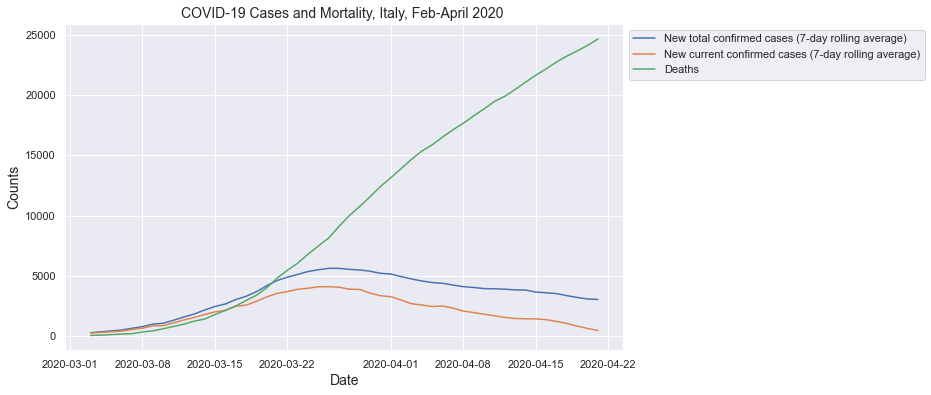

In [884]:
# Lineplots of COVID-19 count data
# Curves are now smoother

sns.lineplot(data=mobility.new_total_confirmed_cases_7day[17:], palette = 'blue', label = 'New total confirmed cases (7-day rolling average)')
sns.lineplot(data=mobility.new_current_confirmed_cases_7day[17:], palette = 'orange', label = 'New current confirmed cases (7-day rolling average)')
sns.lineplot(data=mobility.deaths[17:], palette = 'green', label = 'Deaths')

plt.xlabel("Date", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("COVID-19 Cases and Mortality, Italy, Feb-April 2020 ", fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(0.55, 0., 1, 1))
plt.show()

Both new-current and new-total case numbers increase through to late March.  I'm not entirely sure of the difference between 'new total confirmed' and 'new current confirmed' but assume that the orange line is a plot of daily case tallies minus individuals who have recovered; but this is difficult to determine from the dataset alone. Notably, both the orange and blue counts start to decline from late March, perhaps as a consequence of lockdown.  Deaths on the other hand (a cumulative tally) continue to rise (as expected, since people cannot become undead), but the steepness of the previously exponential curve starts to decline from late March, indicating a small decrease in the rate of death.  Note that there was typically a 14-day lag between infection and showing symptoms with the original SARS-cov2 virus, and that deaths typically lag behind infections and hospitalisations by some weeks. It would be good to see the data plotted alongside the mobility data.

#### 3.3. Converted case count data to fold-change from baseline so that it could be plotted on the same axes as the mobility data

The value for 'current confirmed cases' on Feb 29th, the last day of the first 7-day window, was 228 - so I used this as the denominator for computing the baseline.

The value for 'total confirmed cases' on Feb 29th, the last day of the first 7-day window, was 240 - so I used this as the denominator for computing the baseline.

In [1422]:
#new_current_confirmed_cases_7day_fold_change_from_baseline = np.array(mobility.new_current_confirmed_cases_7day[17:].div(228))
#new_current_confirmed_cases_7day_fold_change_from_baseline = np.round(new_current_confirmed_cases_7day_fold_change_from_baseline, decimals=2)
#new_current_confirmed_cases_7day_fold_change_from_baseline = np.insert(new_current_confirmed_cases_7day_fold_change_from_baseline, 0, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])


#new_total_confirmed_cases_7day_fold_change_from_baseline = np.array(mobility.new_total_confirmed_cases_7day[17:].div(240))
#new_total_confirmed_cases_7day_fold_change_from_baseline = np.round(new_total_confirmed_cases_7day_fold_change_from_baseline, decimals=2)
#new_total_confirmed_cases_7day_fold_change_from_baseline = np.insert(new_total_confirmed_cases_7day_fold_change_from_baseline, 0, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

# Insert new columns into 'mobility' dataframe

#mobility.insert(17, "new_total_confirmed_cases_7day_fold_change_from_baseline", new_total_confirmed_cases_7day_fold_change_from_baseline)
#mobility.new_total_confirmed_cases_7day_fold_change_from_baseline[:9] = mobility.new_total_confirmed_cases_7day_fold_change_from_baseline[:9].replace(0, np.nan)
mobility.tail(5)

,country_region,retail_rec_mv_avg_7day,groc_pharm_mv_avg_7day,parks_mv_avg_7day,transit_mv_avg_7day,workplace_mv_avg_7day,residential_mv_avg_7day,etl_timestamp,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,...,new_current_confirmed_cases,new_current_confirmed_cases_7day_fold_change_from_baseline,new_current_confirmed_cases_7day,new_total_confirmed_cases,new_total_confirmed_cases_7day_fold_change_from_baseline,new_total_confirmed_cases_7day,recovered,deaths,total_confirmed_cases,tests_performed
date,,,,,,,,,,,,,,,,,,,,,
2020-04-17,Italy,-85.29,-54.14,-80.14,-80.29,-67.57,30.57,2022-06-10 00:04:50.466367+00:00,25786,2812,...,355,5.44,1241.29,3493,14.80,3551.00,42727,22745,172434,1244108
2020-04-18,Italy,-85.14,-55.00,-80.00,-80.14,-67.00,30.43,2022-06-10 00:04:50.466367+00:00,25007,2733,...,809,4.70,1071.71,3491,14.08,3379.14,44927,23227,175925,1305833
2020-04-19,Italy,-84.86,-53.29,-79.57,-79.57,-65.86,30.14,2022-06-10 00:04:50.466367+00:00,25033,2635,...,486,3.76,857.71,3047,13.46,3229.86,47055,23660,178972,1356541
2020-04-20,Italy,-82.43,-46.86,-78.57,-77.86,-61.71,28.57,2022-06-10 00:04:50.466367+00:00,24906,2573,...,-20,2.90,660.14,2256,12.92,3101.71,48877,24114,181228,1398024
2020-04-21,Italy,-82.14,-47.43,-78.57,-77.86,-61.14,28.43,2022-06-10 00:04:50.466367+00:00,24134,2471,...,-528,2.14,488.29,2729,12.78,3067.00,51600,24648,183957,1450150


#### 3.4. Plotted Case Data alongside Mobility Data

The dashed lines, showing 'new total confirmed cases' and 'new current confirmed cases', continue to rise for about 14 days after mobility drops, but then peak and start to decline.  This is consistent with a 14-day lag between infection and symptoms, and is consistent with the hypothesis that lockdown reduced transmission (and therefore new case numbers) of SARS-cov2.  Given more time, I could test this by adjusting the 'cases' data to account for lag, and then testing for a significant correlation between the mobility slopes and the case number slopes. 

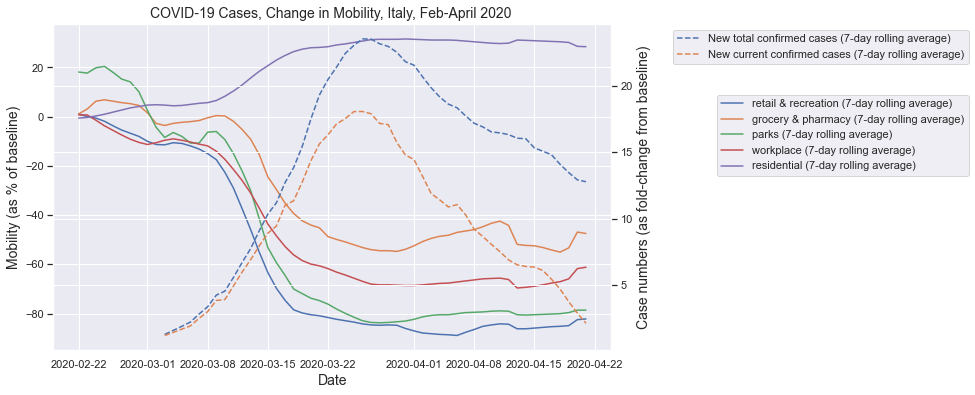

In [1439]:
# Lineplots of 7-day rolling averages alongside daily plots
# I don't know why dates with uneven gaps between them have been selected for the x axis 

import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams['figure.figsize'] = (10, 6)

fig, ax1 = plt.subplots()

sns.lineplot(data=mobility.retail_rec_mv_avg_7day[7:], markers=True, label='retail & recreation (7-day rolling average)', ax=ax1)
sns.lineplot(data=mobility.groc_pharm_mv_avg_7day[7:], markers=".", label ='grocery & pharmacy (7-day rolling average)', ax=ax1)
sns.lineplot(data=mobility.parks_mv_avg_7day[7:], markers=".", label='parks (7-day rolling average)', ax=ax1)
sns.lineplot(data=mobility.workplace_mv_avg_7day[7:], markers=".", label='workplace (7-day rolling average)', ax=ax1)
sns.lineplot(data=mobility.residential_mv_avg_7day[7:], markers=".", label='residential (7-day rolling average)', ax=ax1)

ax2 = plt.twinx()
sns.lineplot(data=mobility.new_total_confirmed_cases_7day_fold_change_from_baseline[17:], palette='grey', markers=".", linestyle="--", label='New total confirmed cases (7-day rolling average)', ax=ax2)
sns.lineplot(data=mobility.new_current_confirmed_cases_7day_fold_change_from_baseline[17:], palette ='black', markers=".", linestyle="--", label ='New current confirmed cases (7-day rolling average)', ax=ax2)

ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("Mobility (as % of baseline)", fontsize=14)
ax2.set_ylabel("Case numbers (as fold-change from baseline)", fontsize=14)
plt.title("COVID-19 Cases, Change in Mobility, Italy, Feb-April 2020 ", fontsize=14)
ax1.legend(loc='best', bbox_to_anchor=(0.65, -0.2, 1, 1))
ax2.legend(loc='best', bbox_to_anchor=(0.65, 0., 1, 1))
plt.show()

### 4. Exploring longer-term COVID-19 data for Italy

#### 4.1 API request for data from 'BigQuery'

In [1443]:
cases = client.get_table(table2_ref) # API Request
sql = """
    SELECT * 
    FROM `pristine-valve-352023.covid_italy.cases` 
    """
query_job = client.query(sql)
cases = client.query(sql).to_dataframe()
cases = cases.sort_values("date")

In [1444]:
# remove time from "date"

from datetime import datetime, date
cases['date'] =  pd.to_datetime(cases['date'])
cases['date'] = pd.to_datetime(cases['date']).dt.date

# Set index as 'date'
cases = cases.set_index('date')
cases.head()

,country,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,tests_performed,note
date,,,,,,,,,,,,,
2020-02-24,ITA,101,26,127,94,221,0,221,1,7,229,4324,None
2020-02-25,ITA,114,35,150,162,311,90,93,1,10,322,8623,None
2020-02-26,ITA,128,36,164,221,385,74,78,3,12,400,9587,None
2020-02-27,ITA,248,56,304,284,588,203,250,45,17,650,12014,None
2020-02-28,ITA,345,64,409,412,821,233,238,46,21,888,15695,None


#### 4.2 EDA

In [1445]:
cases.shape

(837, 13)

In [1446]:
cases.dtypes

country                                 object
hospitalized_patients_symptoms           Int64
hospitalized_patients_intensive_care     Int64
total_hospitalized_patients              Int64
home_confinement_cases                   Int64
total_current_confirmed_cases            Int64
new_current_confirmed_cases              Int64
new_total_confirmed_cases                Int64
recovered                                Int64
deaths                                   Int64
total_confirmed_cases                    Int64
tests_performed                          Int64
note                                    object
dtype: object

In [1447]:
cases = cases.drop(labels=["tests_performed"], axis='columns')

#### 4.3. Graphing Data

I spent a long time trying to make a stacked area plot for the Italy COVID-19 data 2020-2022. But no matter what form I put the data in, I get the following error:

    "TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to      any supported types according to the casting rule ''safe''"
    
Resorted to line graphs instead :-(   

In [1449]:
# Computed 7-day rolling averages using the NumPy .rolling().sum() function, to smooth curves

cases.hospitalized_patients_symptoms = cases.hospitalized_patients_symptoms.rolling(7, min_periods=1).sum()
cases.hospitalized_patients_intensive_care = cases.hospitalized_patients_intensive_care.rolling(7, min_periods=1).sum()
cases.total_hospitalized_patients = cases.total_hospitalized_patients.rolling(7, min_periods=1).sum()
cases.home_confinement_cases = cases.home_confinement_cases.rolling(7, min_periods=1).sum()
cases.total_current_confirmed_cases = cases.total_current_confirmed_cases.rolling(7, min_periods=1).sum()
cases.new_current_confirmed_cases = cases.new_current_confirmed_cases.rolling(7, min_periods=1).sum()
cases.new_total_confirmed_cases = cases.new_total_confirmed_cases.rolling(7, min_periods=1).sum()
cases.recovered = cases.recovered.rolling(7, min_periods=1).sum()
cases.deaths = cases.deaths.rolling(7, min_periods=1).sum()
cases.total_confirmed_cases = cases.total_confirmed_cases.rolling(7, min_periods=1).sum() 

cases.head()

,country,hospitalized_patients_symptoms,hospitalized_patients_intensive_care,total_hospitalized_patients,home_confinement_cases,total_current_confirmed_cases,new_current_confirmed_cases,new_total_confirmed_cases,recovered,deaths,total_confirmed_cases,note
date,,,,,,,,,,,,
2020-02-24,ITA,101.0,26.0,127.0,94.0,221.0,0.0,221.0,1.0,7.0,229.0,None
2020-02-25,ITA,215.0,61.0,277.0,256.0,532.0,90.0,314.0,2.0,17.0,551.0,None
2020-02-26,ITA,343.0,97.0,441.0,477.0,917.0,164.0,392.0,5.0,29.0,951.0,None
2020-02-27,ITA,591.0,153.0,745.0,761.0,1505.0,367.0,642.0,50.0,46.0,1601.0,None
2020-02-28,ITA,936.0,217.0,1154.0,1173.0,2326.0,600.0,880.0,96.0,67.0,2489.0,None


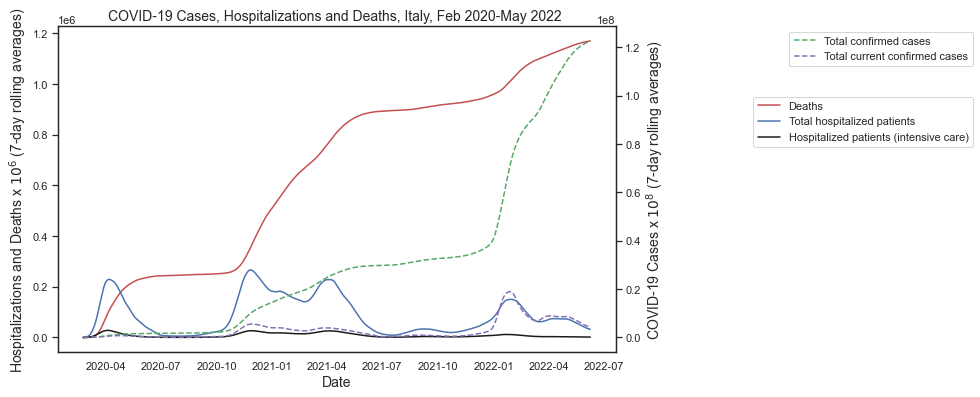

In [1472]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.colors as mcolors
import seaborn as sns
pylab.rcParams['figure.figsize'] = (10, 6)
sns.set(color_codes = True)
sns.set_theme(style="white")

fig, ax1 = plt.subplots()
ax2 = plt.twinx()

sns.lineplot(data=cases.deaths, color="r", label='Deaths', ax=ax1)
sns.lineplot(data=cases.total_hospitalized_patients, color="b", label ='Total hospitalized patients', ax=ax1)
sns.lineplot(data=cases.hospitalized_patients_intensive_care, color="k", label='Hospitalized patients (intensive care)', ax=ax1)


sns.lineplot(data=cases.total_confirmed_cases, color="g", linestyle="--", label='Total confirmed cases', ax=ax2)
sns.lineplot(data=cases.total_current_confirmed_cases, color="m", linestyle="--", label='Total current confirmed cases', ax=ax2)
#sns.lineplot(data=cases.new_current_confirmed_cases, markers=".", label='New current confirmed cases', linestyle="--", ax=ax2)
#sns.lineplot(data=cases.new_total_confirmed_cases, markers=".", label='New total confirmed cases', linestyle="--", ax=ax2)

ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("Hospitalizations and Deaths x $10^6$ (7-day rolling averages)", fontsize=14)
ax2.set_ylabel("COVID-19 Cases x $10^8$ (7-day rolling averages)", fontsize=14)
plt.title("COVID-19 Cases, Hospitalizations and Deaths, Italy, Feb 2020-May 2022 ", fontsize=14)
ax1.legend(loc='best', bbox_to_anchor=(0.65, -0.2, 1, 1))
ax2.legend(loc='best', bbox_to_anchor=(0.65, 0., 1, 1))
plt.show()

In the plot above we can see clearly the three phases of the pandemic. The period April-Oct 2020 is dominated by the Wuhan and other early varients of SARS-cov2.  Deaths and hospitalisations are initially steep in this period, but deaths level off and hospitalisations decline dramatically once social distancing and other measures bring spread of the virus under control, and survivors of the first wave become immune.  The heat of the summer period saw few additional deaths and hospitalisations.  

The second wave, which took off in Oct 2020, has been linked to the return of winter, with deaths and hospitalisations climbing as steeply as they did in the early stages of the pandemic (De Natale et al, 2020).  The seasonal pattern continues in 2021, with summer seeing lower case numbers, hospitalisations and deaths.  Note that the very steep climb in case numbers in Jan 2022 coincides with spread of the more highly infectious 'Omicron' varient, and that the initial death rate in the early Omicron period is not markedly slower than the death rates in earlier waves (though the less mild delta varient was still prevalent at this time). Note also that in spite of the very steep rise in case numbers in the Omicron period is not matched by a similar relative peak increase for deaths and hospitalisations, indicating perhaps a combination of the impact of vaccination and the milder disease symptoms associated with Omicron. 

### 5. Exploring Global COVID-19 Pandemic Data

Global case numbers and data on hospital beds were capita were obtained from bigquery-public-data > covid19_open_data

In [1479]:
# COVID-19 case numbers by country
covid_world = client.get_table(table4_ref)

In [1480]:
# Per capita hospital bed numbers by country
hospital_beds = client.get_table(table5_ref)

In [1481]:
# function to print a table schema:
def printTableSchema(aTable):
    schemas = list(aTable.schema)
    if schemas:
        print('Table schema for {}:'.format(aTable.table_id))
        for aSchema in schemas:
            print('\t{0} {1}'.format(aSchema.name, aSchema.field_type))
        found = True
    else:
        found = False
    return found

In [1476]:
printTableSchema(hospital_beds)

Table schema for hospital_beds:
	country_name STRING
	average_value FLOAT


True

In [1477]:
printTableSchema(covid_world)

Table schema for covid_world_30May2022:
	country_code STRING
	country_name STRING
	may2022_confirmed_cases INTEGER
	population_2018 INTEGER
	case_percent FLOAT


True

In [1482]:
sql = """
    SELECT * 
    FROM `pristine-valve-352023.covid_world.covid_world_30May2022` 
    """
query_job = client.query(sql)
covid_world = client.query(sql).to_dataframe()
covid_world = covid_world.sort_values("country_name")
covid_world = covid_world.set_index("country_name")
covid_world.head()

,country_code,may2022_confirmed_cases,population_2018,case_percent
country_name,,,,
Afghanistan,AF,180347,37172386,0.49
Albania,AL,276172,2866376,9.63
Algeria,DZ,265884,42228429,0.63
American Samoa,AS,6147,55465,11.08
Andorra,AD,42894,77006,55.70


In [975]:
sql = """
    SELECT * 
    FROM `pristine-valve-352023.covid_world.hospital_beds` 
    """
query_job = client.query(sql)
hospital_beds = client.query(sql).to_dataframe()
hospital_beds = hospital_beds.sort_values("country_name")
hospital_beds = hospital_beds.set_index("country_name")
hospital_beds.rename(columns = {'average_value':'avg_hosp_beds_per_1000'}, inplace = True)
hospital_beds.head()

,avg_hosp_beds_per_1000
country_name,
Afghanistan,0.484286
Albania,2.883333
Algeria,1.900000
Antigua and Barbuda,3.098333
Arab World,1.526962


#### 5.1. Combined the Two Dataframes to Combine Hospital Bed Numbers with COVID-19 Case Numbers

In [978]:
#tutorial reference: https://towardsdatascience.com/left-join-with-pandas-data-frames-in-python-c29c85089ba4

covid_world2 = covid_world.merge(hospital_beds, on='country_name', how='left', indicator=True)
covid_world2

,country_code,may2022_confirmed_cases,population_2018,case_percent,avg_hosp_beds_per_1000,_merge
country_name,,,,,,
Afghanistan,AF,180347,37172386,0.49,0.484286,both
Albania,AL,276172,2866376,9.63,2.883333,both
Algeria,DZ,265884,42228429,0.63,1.900000,both
American Samoa,AS,6147,55465,11.08,NaN,left_only
Andorra,AD,42894,77006,55.70,NaN,left_only
...,...,...,...,...,...,...
Venezuela,VE,523625,28870195,1.81,NaN,left_only
Vietnam,VN,10719379,95540395,11.22,2.760000,both
Yemen,YE,11822,28498687,0.04,NaN,left_only


In [989]:
covid_world2.shape

(214, 6)

In [988]:
covid_world2.isnull().sum()

country_code                0
may2022_confirmed_cases     2
population_2018             1
case_percent                3
avg_hosp_beds_per_1000     86
_merge                      0
dtype: int64

#### 5.2. Looked for Correlation between COVID-19 Case Numbers and Hospital Beds per Capita

The R value for correlation between hospital beds per capita and % COVID-19 cases is 0.41, which is worth exploring further.  

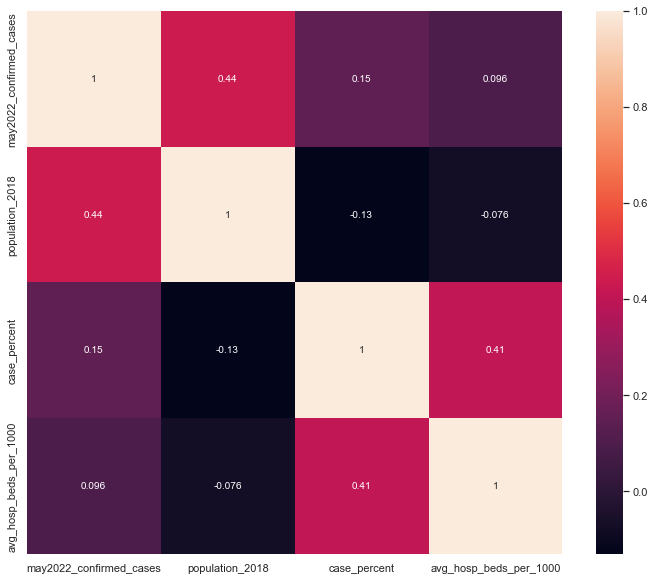

In [986]:
#corr = covid_world2.corrwith(covid_world2['avg_hosp_beds_per_1000'], axis=0) # Gives the correlation scores for wine quality with each of the variables
#corr
covid_world2.dtypes
corr = covid_world2.corr()
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(corr, annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

The scatterplot below shows a positive linear relationship between % of population with COVID-19 and number of hospital beds per capita.  This is surprising because intuitively we'd expect hospital capacity to correlate negatively with COVID deaths, and perhaps also case numbers.  Unfortunately I don't have time to acquire the death data needed to test this hypothesis fully.  For the sake of the exercise, I continued with statistical analysis of this observation. 

Text(0, 0.5, 'average hospital beds per 1000 people')

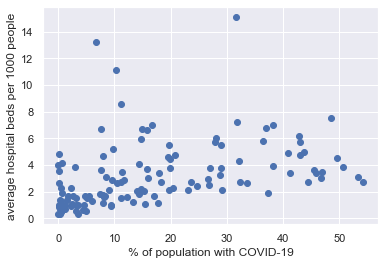

In [994]:
x = covid_world2.case_percent
y = covid_world2.avg_hosp_beds_per_1000
plt.scatter(x,y)
plt.xlabel("% of population with COVID-19", fontsize=12)
plt.ylabel("average hospital beds per 1000 people", fontsize=12)

In [1187]:
# Testing for a significant correlation, using linear regression

covid_world_edited = covid_world2.dropna() # Removed rows with NaN
x = covid_world_edited['case_percent']
y = covid_world_edited['avg_hosp_beds_per_1000']

from scipy import stats
result = stats.linregress(x, y)
print(result)
print(f"R-squared: {result.rvalue**2:.6f}")
print(f"p-value: {result.pvalue:.6f}")

LinregressResult(slope=0.06525718693844355, intercept=2.0673439571576475, rvalue=0.406931122026228, pvalue=2.057843000732114e-06, stderr=0.013102115443703828, intercept_stderr=0.29594097961541316)
R-squared: 0.165593
p-value: 0.000002


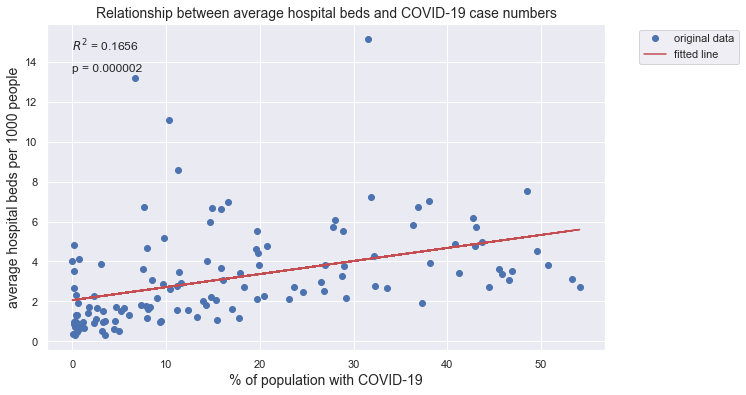

In [1054]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.plot(x, y, 'o', label='original data')
ax = plt.plot(x, result.intercept + result.slope*x, 'r', label='fitted line')
plt.title('Relationship between average hospital beds and COVID-19 case numbers', fontsize=14)
plt.xlabel('% of population with COVID-19', fontsize=14)
plt.ylabel('average hospital beds per 1000 people', fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(0.25, 0., 1, 1))
plt.text(0, 14.5, "$R^2$ = 0.1656", fontsize=12)
plt.text(0, 13.5, "p = 0.000002", fontsize=12)
plt.show()

Regression analysis gives a highly statistically significant result, indicating a positive relationship between hospital bed numbers per capita and COVID-19 case numbers.  This is unlikely to be true and much more likely to be an artefact of poor COVID-19 records in economically-deprived countries. The true case numbers for many of the countries bunched at the low end of the scale is likely to be much higher due to low test rates and large populations.  A better way to test this hypothesis would be to obtain "excess death" data for 2019-2022, assuming that deaths are more accurately counted and reported by all countries than COVID-19 case numbers and deaths. 

#### 5.3. Added Country-by-Continent Data to Categorise Countries by Region and Merged 'covid_world', 'hospital_beds', and 'continents' dataframes

I acquired this data from The World Bank Databank, downloded as a .csv file.  In order to graph the data and use colour to indicate region, I need to be able to map the country names to continent. 

In [1483]:
# Downloaded data from https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent
# Read CSV
continents = pd.read_csv('/Users/gaylecferguson/Data/country_to_continent.csv', header = 0)
continents.rename(columns = {'country':'country_name'}, inplace = True)
continents.head()

,country_name,continent
0,Nigeria,Africa
1,Ethiopia,Africa
2,Egypt,Africa
3,DR Congo,Africa
4,Tanzania,Africa


In [1081]:
# Merged the 'continents' data with the covid_world dataframe

covid_world3 = covid_world.merge(continents, on='country_name', how='left', indicator=True)
covid_world3.head()

,country_name,country_code,may2022_confirmed_cases,population_2018,case_percent,continent,_merge
0,Afghanistan,AF,180347,37172386,0.49,Asia,both
1,Albania,AL,276172,2866376,9.63,Europe,both
2,Algeria,DZ,265884,42228429,0.63,Africa,both
3,American Samoa,AS,6147,55465,11.08,Oceania,both
4,Andorra,AD,42894,77006,55.70,Europe,both


In [1082]:
# Checked for missing values
covid_world3.isnull().sum()

country_name               0
country_code               0
may2022_confirmed_cases    2
population_2018            1
case_percent               3
continent                  7
_merge                     0
dtype: int64

In [1083]:
# Examined rows with missing values for 'continent'
covid_world3.loc[covid_world3['continent'].isna()]

,country_name,country_code,may2022_confirmed_cases,population_2018,case_percent,continent,_merge
46,Curaçao,CW,43953,159849,27.50,NaN,left_only
49,Democratic Republic of the Congo,CD,89356,84068091,0.11,NaN,left_only
54,East Timor,TL,22916,1267972,1.81,NaN,left_only
113,Macedonia,MK,311923,2082958,14.98,NaN,left_only
184,Swaziland,SZ,72510,1136191,6.38,NaN,left_only
188,São Tomé and Príncipe,ST,5982,211028,2.83,NaN,left_only
205,United States of America,US,81519972,327167434,24.92,NaN,left_only


In [1084]:
# Entered continents for the seven countries with missing values

covid_world3.at[46, 'continent'] = "North America"
covid_world3.at[49, 'continent'] = "Africa"
covid_world3.at[54, 'continent'] = "Asia"
covid_world3.at[113, 'continent'] = "Europe"
covid_world3.at[184, 'continent'] = "Africa"
covid_world3.at[188, 'continent'] = "Africa"
covid_world3.at[205, 'continent'] = "North America"

In [1085]:
#Success!
covid_world3.loc[covid_world3['continent'].isna()]

,country_name,country_code,may2022_confirmed_cases,population_2018,case_percent,continent,_merge


In [1089]:
# Merged the 'hospital beds per capita' data with the covid_world dataframe
covid_world4 = covid_world3.merge(hospital_beds, on='country_name', how='left')
covid_world4.head()

,country_name,country_code,may2022_confirmed_cases,population_2018,case_percent,continent,_merge,avg_hosp_beds_per_1000
0,Afghanistan,AF,180347,37172386,0.49,Asia,both,0.484286
1,Albania,AL,276172,2866376,9.63,Europe,both,2.883333
2,Algeria,DZ,265884,42228429,0.63,Africa,both,1.900000
3,American Samoa,AS,6147,55465,11.08,Oceania,both,NaN
4,Andorra,AD,42894,77006,55.70,Europe,both,NaN


#### 5.4. Plotted 'hospital beds per capita' against '% covid-19 cases' with data points coloured by continent and sized by population

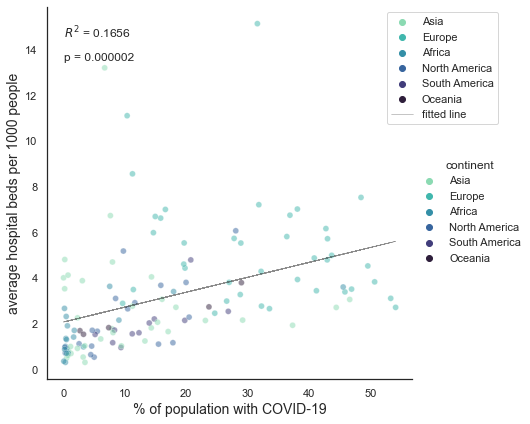

In [1119]:
# When I try to size the dots by 'population_2018' I get error:
# "Cannot interpret 'Int64Dtype()' as a data type"

import seaborn as sns
sns.set_theme(style="white")

covid_world_edited = covid_world4.dropna() # Removed rows with NaN
x = covid_world_edited['case_percent']
y = covid_world_edited['avg_hosp_beds_per_1000']

sns.relplot(x="case_percent", y="avg_hosp_beds_per_1000", hue="continent",
            sizes=(40, 400), alpha=.5, palette="mako_r",
            height=6, data=covid_world_edited)           # size='population_2018' 

plt.plot(x, result.intercept + result.slope*x, 'k', label='fitted line', linewidth=0.5, alpha=0.5)
plt.xlabel('% of population with COVID-19', fontsize=14)
plt.ylabel('average hospital beds per 1000 people', fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(0.25, 0., 1, 1))
plt.text(0, 14.5, "$R^2$ = 0.1656", fontsize=12)
plt.text(0, 13.5, "p = 0.000002", fontsize=12)
plt.show()


#### 5.5. Acquired Data on GDP by Country as a Proxy for Economic Deprivation - Looking at Relationship between COVID-19 Case Numbers and Economic Deprivation

In [1168]:
# Downloaded data from The World Bank https://databank.worldbank.org/source/world-development-indicators#
# Read EXCEL
gdp = pd.read_excel('/Users/gaylecferguson/Data/GDP.xlsx', header = 0)
gdp.rename(columns = {'Country Name':'country_name', '2019 [YR2019]':'GDP_per_cap_2019'}, inplace = True)
gdp = gdp.drop(labels=["Country Code", "Series Name", "Series Code"], axis='columns')
gdp = gdp.drop(labels=["2015 [YR2015]", "2016 [YR2016]", "2017 [YR2017]", "2018 [YR2018]", "2020 [YR2020]", "2021 [YR2021]"], axis='columns')
gdp.head()

,country_name,GDP_per_cap_2019
0,Afghanistan,555.138996
1,Africa Eastern and Southern,1525.165516
2,Africa Western and Central,1852.633574
3,Albania,4544.515005
4,Algeria,4115.39554


In [1186]:
# Merged GDP dataframe with COVID/hospital beds/continents DataFrame

covid_world5 = covid_world4.merge(gdp, on='country_name', how='left')
covid_world5

,country_name,country_code,may2022_confirmed_cases,population_2018,case_percent,continent,_merge,avg_hosp_beds_per_1000,GDP_per_cap_2019
0,Afghanistan,AF,180347,37172386,0.49,Asia,both,0.484286,555.138996
1,Albania,AL,276172,2866376,9.63,Europe,both,2.883333,4544.515005
2,Algeria,DZ,265884,42228429,0.63,Africa,both,1.900000,4115.39554
3,American Samoa,AS,6147,55465,11.08,Oceania,both,NaN,11368.56958
4,Andorra,AD,42894,77006,55.70,Europe,both,NaN,39003.384448
...,...,...,...,...,...,...,...,...,...
209,Venezuela,VE,523625,28870195,1.81,South America,both,NaN,NaN
210,Vietnam,VN,10719379,95540395,11.22,Asia,both,2.760000,2604.224166
211,Yemen,YE,11822,28498687,0.04,Asia,both,NaN,NaN
212,Zambia,ZM,321779,17351822,1.85,Africa,both,NaN,1348.738357


In [1171]:
# Checked for null values
# Will remove rows with null values in the cell below
covid_world5.isnull().sum()

country_name                0
country_code                0
may2022_confirmed_cases     2
population_2018             1
case_percent                3
continent                   0
_merge                      0
avg_hosp_beds_per_1000     86
GDP_per_cap_2019           33
dtype: int64

#### 5.6. Plotted 'hospital beds per capita' against '% COVID-19 cases' with data points coloured by continent and sized by GDP per capita (2019)

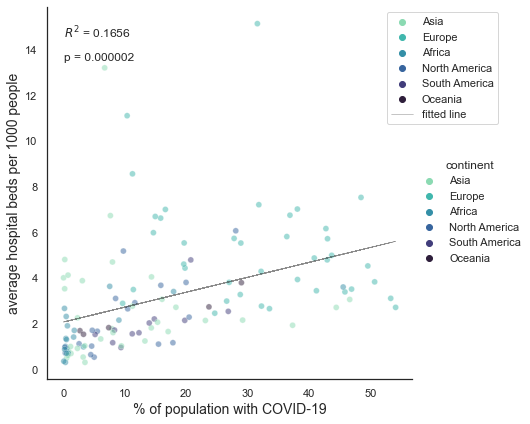

In [1486]:
# I can't get it to display the legend without including a legend for every size of dot
# So had to remove the "size" argument

import seaborn as sns
sns.set_theme(style="white")

covid_world_edited = covid_world5.dropna() # Removed rows with NaN
x = covid_world_edited['case_percent']
y = covid_world_edited['avg_hosp_beds_per_1000']

ax = sns.relplot(x="case_percent", y="avg_hosp_beds_per_1000", hue="continent",
            sizes=(40, 400), alpha=.5, palette="mako_r", height=6, 
                 data=covid_world_edited, legend=True)      # size='GDP_per_cap_2019'          

plt.plot(x, result.intercept + result.slope*x, 'k', label='fitted line', linewidth=0.5, alpha=0.5)
plt.xlabel('% of population with COVID-19', fontsize=14)
plt.ylabel('average hospital beds per 1000 people', fontsize=14)

#h,l = ax.get_legend_handles_labels()
plt.legend(loc='best', bbox_to_anchor=(0.25, 0., 1, 1))

plt.text(0, 14.5, "$R^2$ = 0.1656", fontsize=12)
plt.text(0, 13.5, "p = 0.000002", fontsize=12)
plt.show()

#### 5.7. Tested for a Correlation between GDP per capita and COVID-19 case numbers

In [1180]:
# Testing for a significant correlation, using linear regression

covid_world_edited = covid_world5.dropna()
x = covid_world_edited['case_percent']
y = covid_world_edited['GDP_per_cap_2019'].astype(float)

from scipy import stats
result = stats.linregress(x, y)
print(result)
print(f"R-squared: {result.rvalue**2:.6f}")
print(f"p-value: {result.pvalue:.6f}")

LinregressResult(slope=932.280586365805, intercept=2638.0879273118517, rvalue=0.5682660742723691, pvalue=3.205604582850829e-12, stderr=120.7418615008458, intercept_stderr=2727.228662171493)
R-squared: 0.322926
p-value: 0.000000


Regression analysis gives a highly statistically significant result, indicating a positive relationship between GDP per capita (2019) and '% COVID-19 cases'. This is unlikely to be true and much more likely to be an artifact of poor COVID-19 records in economically-deprived countries. The true case numbers for many of the countries bunched at the low end of the scale is likely to be much higher due to low test rates and large populations. A better way to test this hypothesis would be to obtain "excess death" data for 2019-2022, assuming that deaths are more accurately counted and reported by all countries than COVID-19 case numbers and deaths.

#### 5.8. Plotted 'GDP per capita' against '% COVID-19 cases' with data points coloured by continent and sized by hospital beds per capita

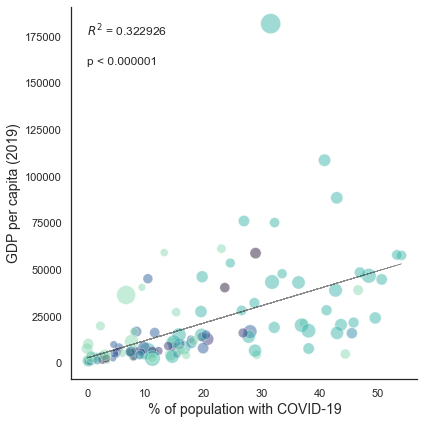

In [1183]:
# I can't get it to display the legend without including a legend for every size of dot
# Legend is same as for graph above
# Would be good to label some of the data points with country_name

import seaborn as sns
sns.set_theme(style="white")

covid_world_edited = covid_world5.dropna() # Removed rows with NaN
x = covid_world_edited['case_percent']
y = covid_world_edited['GDP_per_cap_2019'].astype(float)

sns.relplot(x="case_percent", y="GDP_per_cap_2019", hue="continent",
            sizes=(40, 400), alpha=.5, palette="mako_r",
            size='avg_hosp_beds_per_1000', height=6, data=covid_world_edited, legend=False)           

plt.plot(x, result.intercept + result.slope*x, 'k', label='fitted line', linewidth=0.5, alpha=0.5)
plt.xlabel('% of population with COVID-19', fontsize=14)
plt.ylabel('GDP per capita (2019)', fontsize=14)

#h,l = ax.get_legend_handles_labels()
#plt.legend(loc='best', bbox_to_anchor=(0.25, 0., 1, 1))

plt.text(0, 175000, "$R^2$ = 0.322926", fontsize=12)
plt.text(0, 160000, "p < 0.000001", fontsize=12)
plt.show()

## Conclusions

1. Is there evidence that restrictions on individual movement and imposition of a residential lockdown in            Italy in March 2020 reduced case numbers, deaths and hospitalisations due to COVID-19?
       
       Yes.  I did not formally test it, but the graphs of the 'smoothed' data clearly showed a dramatic impact of        lockdown on social mobility that was visually correlated with a 2-week-lagged drop in new COVID-19 cases.   

2. Is there a relationship between case numbers (as % of population infected) and number of hospital beds
   per capita?
     
        Yes, but it is a counterintuitive relationship, indicating that increasing '% cases' correlate with               increasing numbers of hospital beds per capita, which is unlikely to be true and is most likely an         
        artefact of low testing rates and extreme under-reporting of true COVID-19 case rates in economically     
        deprived countries.  This hypothesis would be better tested by comparing 'excess deaths' with 'hospital 
        beds per capita' before and during the pandemic.    

3.  Is there a relationship between case numbers (as % of population infected) and economic deprivation                (using GDP as a proxy for economic deprivation)?
 
         Similarly, but is a counterintuitive relationship, indicating that increasing '% cases' correlate with            increasing GDP per capita, which is unlikely to be true and is most likely also a consequence of the    
         artefact described above. 

### References

De Natale, G., De Natale, L., Troise, C., Marchitelli, V., Coviello, A., Holmberg, K. G., & Somma, R. (2020). The Evolution of Covid-19 in Italy after the Spring of 2020: An Unpredicted Summer Respite Followed by a Second Wave. International Journal of Environmental Research and Public Health, 17(23), 8708. https://doi.org/10.3390/ijerph17238708

Migliaccio M, Buono A, Maltese I, Migliaccio M. (2021). The 2020 Italian Spring Lockdown: A Multidisciplinary Analysis over the Milan Urban Area. World, 2(3), 391-414. https://doi.org/10.3390/world2030025

## - END -

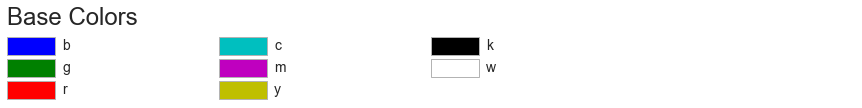

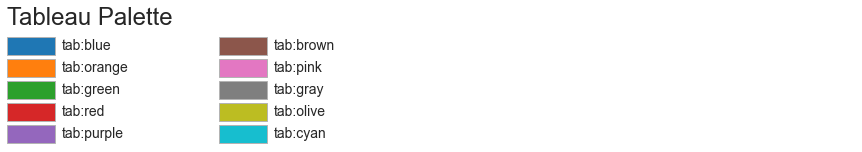

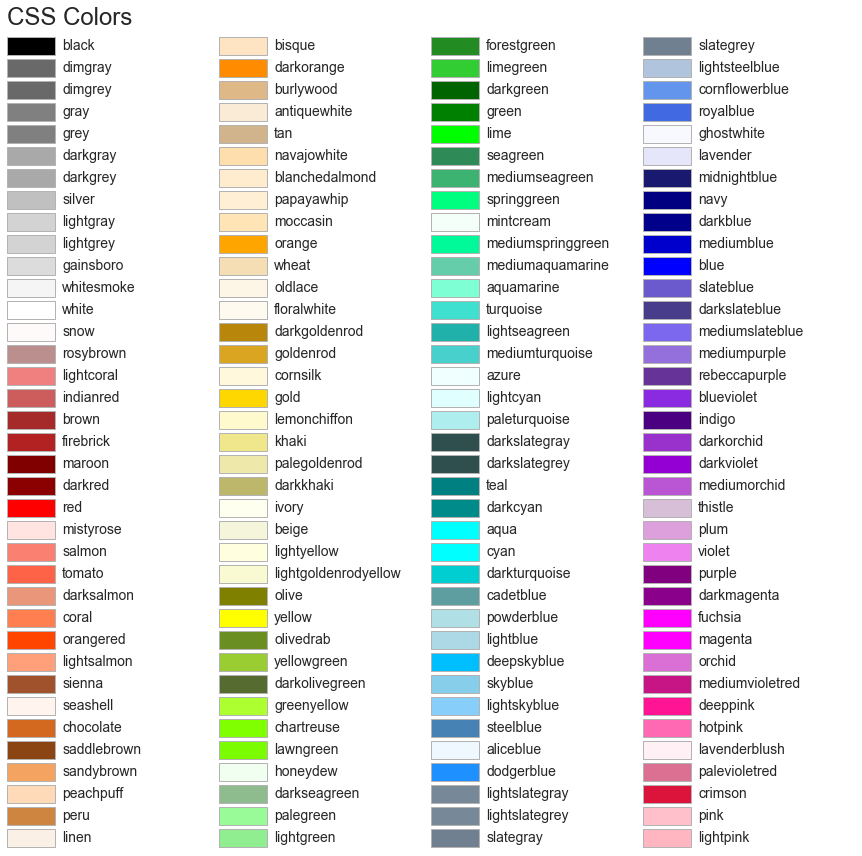

In [1487]:
# This is cool!


from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

plot_colortable(mcolors.BASE_COLORS, "Base Colors",
                sort_colors=False, emptycols=1)
plot_colortable(mcolors.TABLEAU_COLORS, "Tableau Palette",
                sort_colors=False, emptycols=2)

plot_colortable(mcolors.CSS4_COLORS, "CSS Colors")

# Optionally plot the XKCD colors (Caution: will produce large figure)
# xkcd_fig = plot_colortable(mcolors.XKCD_COLORS, "XKCD Colors")
# xkcd_fig.savefig("XKCD_Colors.png")

plt.show()


>
>


>
>




---



---



> > > > > > > > > © 2022 Institute of Data


---



---



